In [47]:
import pandas as pd
# pip install bs4   
from bs4 import BeautifulSoup
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor


Załadowanie ocen z zbiory jester

In [98]:
# pip install xlrd
ratings_data = pd.read_excel('jester_dataset_1_1/jester-data-1.xls', header=None)
ratings_data = ratings_data.iloc[:, 1:].replace(99, float('nan'))
ratings = ratings_data.mean()

# show top 10 jokes
print(ratings.sort_values(ascending=False)[:10])


50    3.665085
89    3.574720
36    3.312500
27    3.189821
32    3.155988
35    3.006351
62    2.976021
29    2.972455
53    2.939463
49    2.771298
dtype: float64


Załadowanie żartów ze zbioru jester

In [101]:
jokes_data = []

for i in range(1, 101):
    file_name = f'jokes/init{i}.html'
    with open(file_name, 'r') as file:
        joke_html = file.read()
        soup = BeautifulSoup(joke_html, 'html.parser')
        joke_text = soup.find('font', size='+1').text.strip()
        jokes_data.append(joke_text)

# show 50th joke
print(jokes_data[88])

A radio conversation of a US naval 
ship with Canadian authorities ... 

Americans: Please divert your course 15 degrees to the North to avoid a
collision.

Canadians: Recommend you divert YOUR course 15 degrees to the South to 
avoid a collision.

Americans: This is the Captain of a US Navy ship.  I say again, divert 
YOUR course.

Canadians: No.  I say again, you divert YOUR course.

Americans: This is the aircraft carrier USS LINCOLN, the second largest ship in the United States' Atlantic Fleet. We are accompanied by three destroyers, three cruisers and numerous support vessels. I demand that you change your course 15 degrees north, that's ONE FIVE DEGREES NORTH, or counter-measures will be undertaken to ensure the safety of this ship.

Canadians: This is a lighthouse.  Your call.


In [50]:
# display first 5 jokes
print(jokes_data[:5])

['A man visits the doctor. The doctor says "I have bad news for you.You have\ncancer and Alzheimer\'s disease". \nThe man replies "Well,thank God I don\'t have cancer!"', 'This couple had an excellent relationship going until one day he came home\nfrom work to find his girlfriend packing. He asked her why she was leaving him\nand she told him that she had heard awful things about him. \n\n"What could they possibly have said to make you move out?" \n\n"They told me that you were a pedophile." \n\nHe replied, "That\'s an awfully big word for a ten year old."', "Q. What's 200 feet long and has 4 teeth? \n\nA. The front row at a Willie Nelson Concert.", "Q. What's the difference between a man and a toilet? \n\nA. A toilet doesn't follow you around after you use it.", "Q.\tWhat's O. J. Simpson's Internet address? \nA.\tSlash, slash, backslash, slash, slash, escape."]


transrormacja danych do postaci macierzy

In [51]:
model = SentenceTransformer('bert-base-cased')
embeddings = model.encode(jokes_data)

No sentence-transformers model found with name C:\Users\filip/.cache\torch\sentence_transformers\bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\filip/.cache\torch\sentence_transformers\bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model 

podizelenie danych na zbiór treningowy i walidacyjny

In [103]:
train_X, val_X, train_y, val_y = train_test_split(embeddings, ratings, test_size=0.2,
                                                  random_state=2)

In [77]:
print("Train X shape:", train_X.shape)
print("Train y shape:", train_y.shape)
print("Validation X shape:", val_X.shape)
print("Validation y shape:", val_y.shape)

Train X shape: (80, 768)
Train y shape: (80,)
Validation X shape: (20, 768)
Validation y shape: (20,)


In [88]:
# stotne jest, by zacząć eksperymenty od możliwie jak najbardziej surowej sieci neuronowej. Jeśli
# korzystasz z Pythona i pakietu sklearn, konkretnie klasy sklearn.neural network.MLPRegressor,
# upewnij się, że przekazujesz następujące wartości hiperparametrów:
# • solver = ’sgd’
# • alpha = 0.0
# • learning rate = ’constant’

def run(learning_rate_param=0.001, hidden_sizes=(100,), loss_type='train') -> list:
    mlp = MLPRegressor(solver='sgd', 
                       alpha=0.0, 
                       learning_rate='constant',
                       learning_rate_init=learning_rate_param, 
                       hidden_layer_sizes=hidden_sizes,
                       random_state=0
                       )
    train_loss = []
    val_loss = []
    epochs = 500

    for epoch in range(epochs):
        mlp.partial_fit(train_X, train_y)

        pred_train_y = mlp.predict(train_X)
        train_loss.append(mean_squared_error(train_y, pred_train_y))

        pred_val_y = mlp.predict(val_X)
        val_loss.append(mean_squared_error(val_y, pred_val_y))

    train_loss2 = mlp.loss_curve_

    if loss_type == 'train':
        return train_loss
    elif loss_type == 'val':
        return val_loss
    elif loss_type == 'loss':
        return train_loss2
    else:
        raise ValueError(f"Invalid loss_type: {loss_type}. Use 'train' or 'val'.")


2. Przetestuj działanie podstawowego modelu MLP o domyślnej konfiguracji hiperparametrów,
ucząc go na danych ze zbioru Jester. Prześledź zachowanie modelu w czasie, wizualizując
wartość funkcji kosztu w funkcji liczby epok, zwracając uwagę na wartości dla zbioru uczącego
i zbioru walidacyjnego. (20 punktów

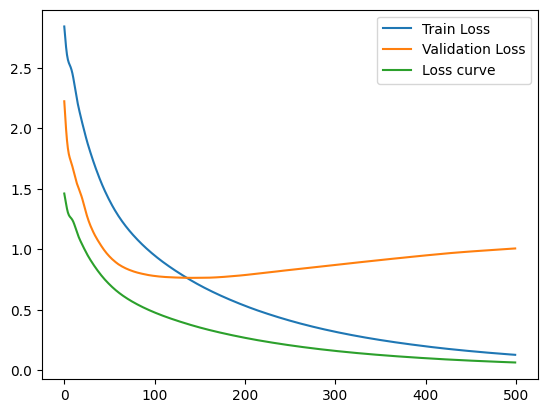

In [89]:
loss_train = run(loss_type='train')
loss_val = run(loss_type='val')
loss_curve = run(loss_type='loss')
plt.plot(range(len(loss_train)), loss_train, label=f'Train Loss')
plt.plot(range(len(loss_val)), loss_val, label=f'Validation Loss')
plt.plot(range(len(loss_curve)), loss_curve, label=f'Loss curve')
plt.legend()
plt.show()

3. Zbadaj wpływ tempa uczenia (learning rate) na osiągane wyniki: powtórz uczenie dla 3 różnych wartości parametru. Dobierz odpowiednią długość procesu uczenia (liczbę epok) jeśli to
konieczne. Przedstaw wyniki na wykresach jak w zadaniu poprzednim. Co dzieje się, gdy tempo
uczenia jest zbyt niskie? Co, gdy zbyt wysokie? (30 punktów)


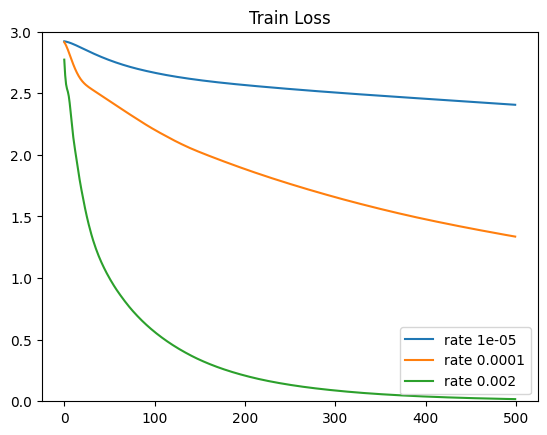

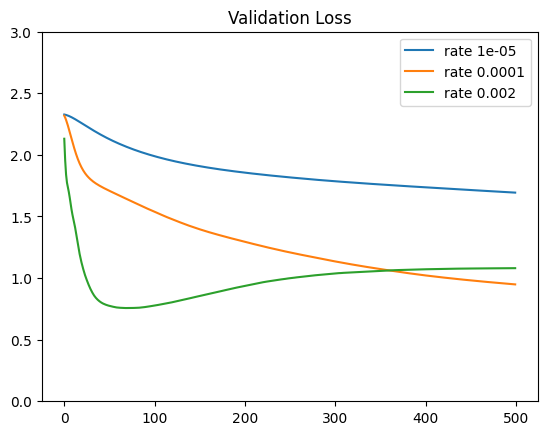

In [93]:
learning_rates = [0.00001, 0.0001, 0.002]

for lr in learning_rates:
    train_loss =  run(learning_rate_param=lr, loss_type='train')
    plt.plot(range(len(train_loss)), train_loss, label=f'rate {lr}')
plt.title('Train Loss')
plt.ylim(0, 3)
plt.legend()
plt.show()
    
for lr in learning_rates:
    val_loss =  run(learning_rate_param=lr, loss_type='val')
    plt.plot(range(len(val_loss)), val_loss, label=f'rate {lr}')
plt.title('Validation Loss')
plt.ylim(0, 3)
plt.legend()
plt.show()

4. Zbadaj wpływ rozmiaru modelu MLP na jakość działania: wykonaj co najmniej 3 eksperymenty
dla modeli różniących się liczbą neuronów. Kiedy model przestaje dobrze dopasowywać się do
danych? Kiedy zaczyna zanadto dopasowywać się do zbioru uczącego? (30 punktów)

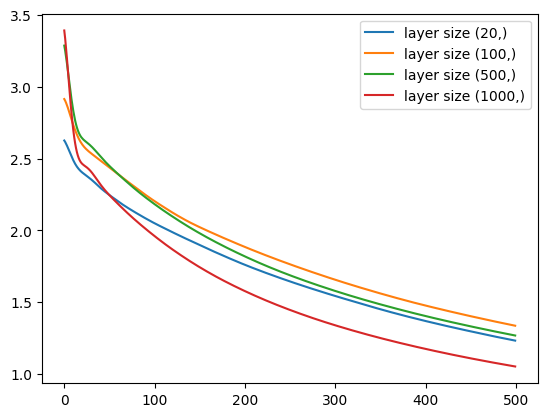

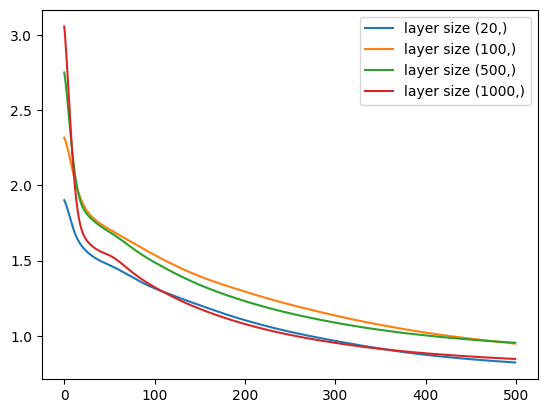

In [92]:
hidden_layer_sizes = [(20,), (100,), (500,), (1000,)]

for size in hidden_layer_sizes:
    loss_train = run(0.0001, hidden_sizes=size, loss_type='train')
    plt.plot(range(len(loss_train)), loss_train, label=f'layer size {size}')
plt.title('Train Loss')
plt.legend()
plt.show()

for size in hidden_layer_sizes:
    loss_val = run(0.0001, hidden_sizes=size, loss_type='val')
    plt.plot(range(len(loss_val)), loss_val, label=f'layer size {size}')
plt.title('Validation Loss')
plt.legend()
plt.show()

5. Wybierz najlepszy uzyskany w drodze powyższych eksperymentów model i przetestuj go w
praktyce: znajdź (lub napisz własny) tekst o charakterze dowcipu, przetwórz go na wektor za
pomocą używanej w zadaniach metody ekstrakcji cech, a następnie odpytaj model neuronowy.
Czy predykcja zgadza się z Twoim oczekiwaniem? (15 punktów)

In [104]:
my_mlp = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant',
                      learning_rate_init=0.0001, hidden_layer_sizes=(20,), max_iter=400)
# my_mlp = MLPRegressor()

my_mlp.fit(train_X, train_y)


def my_joke(joke):
    joke_embedding = model.encode([joke])
    joke_embedding = np.reshape(joke_embedding, (1, -1))
    rating_prediction = my_mlp.predict(joke_embedding)
    print("Predykcja oceny żartu:", rating_prediction)


# my_joke("What kind of dog does a magician have? A Labracadabrador!")
# my_joke("What's the best thing about Switzerland?, I don't know but the flag is a big plus")
# my_joke("The other day, my wife asked me to pass her lipstick, but I accidentally passed her a glue stick. She still "
#         "isn’t talking to me.")
# my_joke("My boss told me to have a good day. So I went home.")


joke = '''A man enters a confessional booth and confesses to the priest, saying, "Father, I have something to confess. I'm 80 years old, a widower, and I have 11 grandchildren. Last night, I had an incredible encounter with two stunning flight attendants. They accompanied me home, and we made love not once, but twice!"

The priest, slightly taken aback, asks, "My son, when was the last time you went to confession?"

The man replies, "Never, Father. I'm Jewish."

Confused, the priest asks, "Then why are you telling me?"

The man grins and says, "Oh, I'm telling everyone!"'''


my_joke("What do you call a fish with no eyes? A fsh.")
my_joke(joke)

joke = '''A radio conversation of a US naval 
ship with Canadian authorities ... 

Americans: Please divert your course 15 degrees to the North to avoid a
collision.

Canadians: Recommend you divert YOUR course 15 degrees to the South to 
avoid a collision.

Americans: This is the Captain of a US Navy ship.  I say again, divert 
YOUR course.

Canadians: No.  I say again, you divert YOUR course.

Americans: This is the aircraft carrier USS LINCOLN, the second largest ship in the United States' Atlantic Fleet. We are accompanied by three destroyers, three cruisers and numerous support vessels. I demand that you change your course 15 degrees north, that's ONE FIVE DEGREES NORTH, or counter-measures will be undertaken to ensure the safety of this ship.

Canadians: This is a lighthouse.  Your call.'''

my_joke(joke)


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Predykcja oceny żartu: [-0.36106837]
Predykcja oceny żartu: [1.2481736]
Predykcja oceny żartu: [1.2688947]
